## Data analysis practice - building regression

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We will analyse data of the women survey from Botswana. 

Load the data:

In [2]:
botswana = pd.read_csv('botswana.tsv', sep = '\t')
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


There is an information about women like:
 * *ceb* - number of children
 * *age* - age
 * *educ* - duration of education
 * *religion* - religion
 * *idlnchld* - ideal number of children in a family, by their opinion
 * *knowmeth* - does she know about contraceptive methods
 * *usemeth* - does she use contraceptive methods
 * *evermarr* - was the woman ever married
 * *agefm* - age of a first marriage
 * *heduc* - duration of husband's education
 * *urban* - does she live in a city
 * *electric, radio, tv, bicycle* - does she have electricity, radio, tv and bike

Our goal is to learn how to estimate the number of children.

Firstly, examine the data.

In [3]:
botswana.shape

(4361, 15)

In [4]:
botswana.describe()

,ceb,age,educ,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
count,4361.000000,4361.000000,4361.000000,4241.000000,4354.000000,4290.000000,4361.000000,2079.000000,1956.000000,4361.000000,4358.000000,4359.000000,4359.000000,4358.000000
mean,2.441642,27.405182,5.855996,4.615892,0.963252,0.577622,0.476726,20.686388,5.144683,0.516625,0.140202,0.701766,0.092911,0.275815
std,2.406861,8.685233,3.927075,2.219303,0.188164,0.493996,0.499515,5.002383,4.803028,0.499781,0.347236,0.457535,0.290341,0.446975
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,20.000000,3.000000,3.000000,1.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,26.000000,7.000000,4.000000,1.000000,1.000000,0.000000,20.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,4.000000,33.000000,8.000000,6.000000,1.000000,1.000000,1.000000,23.000000,8.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,13.000000,49.000000,20.000000,20.000000,1.000000,1.000000,1.000000,46.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
botswana.religion.value_counts()

spirit        1841
other         1080
protestant     993
catholic       447
Name: religion, dtype: int64

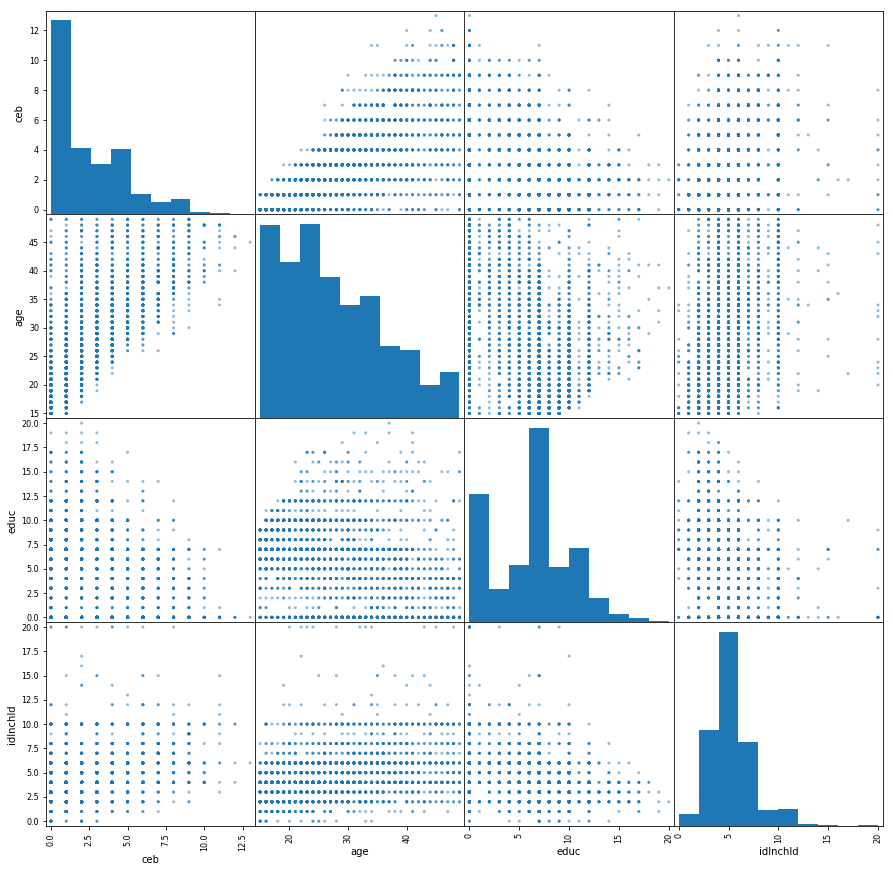

In [6]:
pd.plotting.scatter_matrix(botswana[['ceb', 'age', 'educ', 'idlnchld']], figsize=(15, 15), diagonal = 'hist')
pylab.show()

Estimate the balance of the sample for categorical variables:

In [7]:
print(botswana.knowmeth.value_counts())
print(botswana.usemeth.value_counts())
print(botswana.evermarr.value_counts())
print(botswana.urban.value_counts())
print(botswana.electric.value_counts())
print(botswana.radio.value_counts())
print(botswana.tv.value_counts())
print(botswana.bicycle.value_counts())

1.0    4194
0.0     160
Name: knowmeth, dtype: int64
1.0    2478
0.0    1812
Name: usemeth, dtype: int64
0    2282
1    2079
Name: evermarr, dtype: int64
1    2253
0    2108
Name: urban, dtype: int64
0.0    3747
1.0     611
Name: electric, dtype: int64
1.0    3059
0.0    1300
Name: radio, dtype: int64
0.0    3954
1.0     405
Name: tv, dtype: int64
0.0    3156
1.0    1202
Name: bicycle, dtype: int64


How we can see, there are missing values in several varuables. For example, in *agefm* and *heduc* there isn't value if *evermarr = 0*. 

Create a new variable *nevermarr* with value = 1, where *agefm* has no value. Then delete variable *evermarr* to avoid multicollinearity.

In [8]:
botswana['nevermarr'] = botswana['evermarr'].apply(lambda x : 1 if x==0 else 0)
botswana.drop('evermarr', axis=1, inplace=True)

Replace missing values in *agefm* by 0:

In [9]:
botswana.agefm.fillna(0, inplace = True)

In [10]:
botswana['heduc']=botswana.apply(lambda botswana: -1 if pd.isnull(botswana['heduc']) and botswana['nevermarr']==1 
                                 else botswana['heduc'], axis=1)

Get rid of the rest of missing values:

In [11]:
botswana['idlnchld_noans'] = botswana['idlnchld'].apply(lambda x : 1 if pd.isnull(x) else 0)
botswana['heduc_noans'] = botswana['heduc'].apply(lambda x : 1 if pd.isnull(x) else 0)
botswana['usemeth_noans'] = botswana['usemeth'].apply(lambda x : 1 if pd.isnull(x) else 0)
botswana.idlnchld.fillna(-1, inplace = True)
botswana.heduc.fillna(-2, inplace = True)
botswana.usemeth.fillna(-1, inplace = True)
botswana = botswana.dropna(axis=0,how='any',subset=['knowmeth', 'electric', 'radio', 'tv', 'bicycle'])

In [12]:
botswana.columns

Index(['ceb', 'age', 'educ', 'religion', 'idlnchld', 'knowmeth', 'usemeth',
       'agefm', 'heduc', 'urban', 'electric', 'radio', 'tv', 'bicycle',
       'nevermarr', 'idlnchld_noans', 'heduc_noans', 'usemeth_noans'],
      dtype='object')

Now there are no missing values in our dataset and it's ready for analysis.

Build a regression for the number of children *ceb* for all variables:

In [13]:
mod = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth + agefm + heduc +'\
                  'urban + electric + radio + tv + bicycle + nevermarr + idlnchld_noans +heduc_noans + usemeth_noans', 
             data=botswana)
fitted = mod.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:26:32   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

Look at the distribution of residuals:

/Users/luda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


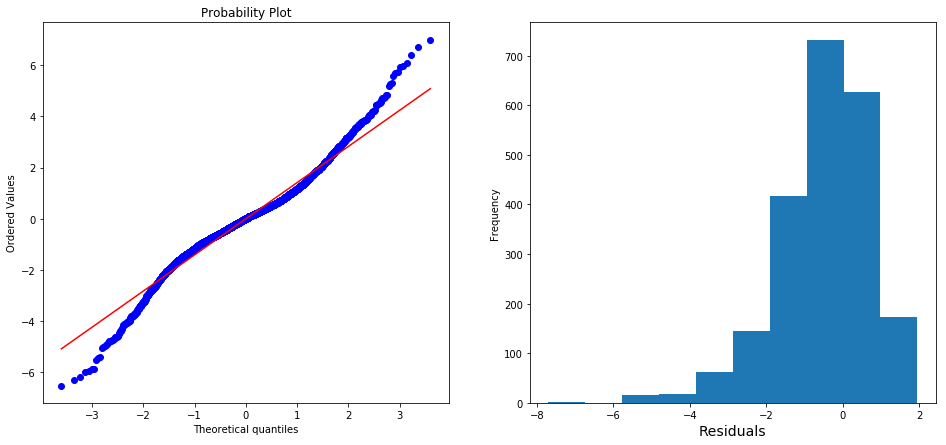

In [14]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

Check the homoscedasticity of errors:

In [15]:
print('Breusch-Pagan test:', 'p =', sms.het_breushpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p = 1.1452927633439797e-225


/Users/luda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')
  """Entry point for launching an IPython kernel.


Errors are heteroscedastic, which means that the significance of variables may be determined incorrectly. 
Make the White's correction:

In [16]:
mod2 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth + agefm + heduc +'\
                  'urban + electric + radio + tv + bicycle + nevermarr + idlnchld_noans +heduc_noans + usemeth_noans', 
             data=botswana)
fitted = mod2.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     345.0
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:26:38   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

Remove some insignificant variables from the model (*religion, radio* and *tv*) and see if the model has become significantly worse from removing three variables using Fisher's test:

In [17]:
mod3 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + heduc +'\
                  'urban + electric + bicycle + nevermarr + idlnchld_noans +heduc_noans + usemeth_noans', 
             data=botswana)
fitted = mod3.fit(cov_type='HC1')

In [18]:
print("F=%f, p=%f, k1=%f" % mod2.fit().compare_f_test(mod3.fit()))

F=0.919236, p=0.467231, k1=5.000000


p-value is large enough, it means that the deleted variables did not make the model worse

Do the same with *usemeth*:

In [19]:
mod4 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + agefm + heduc +'\
                  'urban + electric + bicycle + nevermarr + idlnchld_noans +heduc_noans', 
             data=botswana)
fitted = mod4.fit(cov_type='HC1')
mod3.fit().compare_f_test(mod4.fit())

(92.89058230109622, 3.1552009480426394e-40, 2.0)

p-value is small, we can't remove *usemeth* from the model

In [20]:
model = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + heduc +'\
                  'urban + electric + bicycle + nevermarr + idlnchld_noans +heduc_noans + usemeth_noans', 
             data=botswana)
fitted = model.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:26:45   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

Check if there are any observations that influence the regression equation too much:

<Figure size 576x504 with 0 Axes>

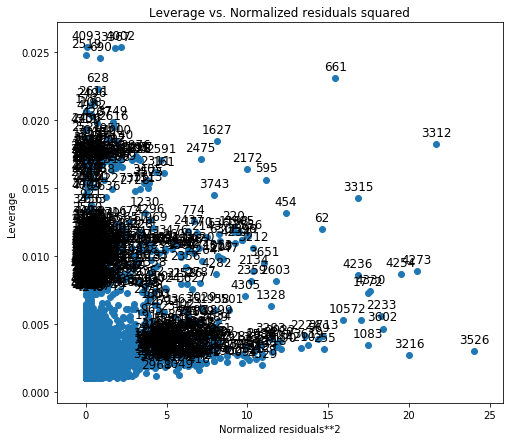

In [21]:
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

In [22]:
botswana.loc[[661]]

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
661,11,47,0,other,-1.0,1.0,1.0,39.0,-2.0,1,0.0,1.0,0.0,0.0,0,1,1,0


In [23]:
botswana.loc[[3312]]

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
3312,11,46,0,other,3.0,0.0,0.0,44.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0


In [24]:
botswana.loc[[3526]]

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
3526,13,45,0,protestant,6.0,1.0,0.0,27.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0


### Conclusion

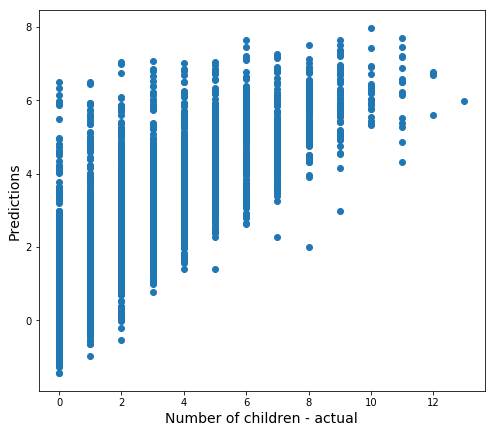

In [25]:
scatter(botswana['ceb'], fitted.fittedvalues)
plt.xlabel('Number of children - actual', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
pylab.show()

* The resulting model explains 64% target variation;
* With an increase in the age of a woman for 1 year, the average number of children increases by 0.17;
* Women who do not know how many children is ideal, on average,  has 0.58 more children;
* Women who never married, with other things being equal, has on average 2.3 children less.